In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../Style.mplstyle')
import pandas as pd
import os
import sys
import scipy
import matplotlib.dates as mdates
from datetime import datetime
from iminuit import Minuit
from scipy import stats
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.stats import chi2
sys.path.append('..')
from read_data_functions import *
from plot_functions import *
from calculations import *

In [2]:
parent_path = '../../../../'
path = 'L:/PG-Nanoteknologi/PROJEKTER/2024 Laura og Nan/Lund/'

SMPS = read_SMPS(path, parent_path, [0, 0])
OPS_APS = read_OPS(path, parent_path)

NS_dict_keys = ['2024-10-15_NanoScan', '2024-10-16_NanoScan', '2024-10-17_NanoScan']
NS_bins = SMPS['2024-10-21_NanoScan'].keys()[3:16].to_list()

NS_bg_mean, NS_bg_std, NS_bg_error = bin_mean(['2024/10/21 11:45:00', '2024/10/21 14:10:00'], 
                                              SMPS['2024-10-21_NanoScan'], NS_bins, 'Time', 0.1)

for key in NS_dict_keys:
    df = SMPS[key]
    for i, bin in enumerate(NS_bins):
        df[bin] = df[bin] - NS_bg_mean[i]

    SMPS[key] = df

Failed to read file with separation: 	
Failed to read file with separation: ,
Failed to read file with separation: ,
Failed to read file with separation: 	
Failed to read file with separation: ,
Failed to read file with separation: ,


In [3]:
APS_dict_keys = ['20241016_APS', '20241016_APS_2_exp', '20241017_APS', '20241017_APS']
APS_bins = OPS_APS['20241016_APS'].keys()[1:53].to_list()
APS_bin_mean = [(0.486968 + 0.523)/2]
for key in OPS_APS['20241016_APS'].keys()[2:53]:
    APS_bin_mean.append(float(key))
    OPS_APS['20241016_APS'][key] = pd.to_numeric(OPS_APS['20241016_APS'][key], errors='coerce') * 7.86
APS_cut_point = np.concatenate(([0.486968], (np.array(APS_bin_mean)[1:]+np.array(APS_bin_mean)[:-1])/2, [20.53]))

APS_mass_conc = {}
APS_mass_conc['20241016_APS'] = OPS_APS['20241016_APS']
for key in APS_dict_keys[1:3]:
    for i, bin in enumerate(APS_bins):
        bin_width = np.log10(APS_cut_point[i+1]) - np.log10(APS_cut_point[i])
        OPS_APS[key][bin] = pd.to_numeric(OPS_APS[key][bin]) * bin_width
    mass_conc = calc_mass_conc(OPS_APS[key], APS_bins, APS_bin_mean, 7.86)
    APS_mass_conc[key] = mass_conc

APS_number = pd.DataFrame({'Time': OPS_APS['20241016_APS']['Time']})
for i, key in enumerate(APS_bins):
        # Ensure df[key] is numeric
        OPS_APS['20241016_APS'][key] = pd.to_numeric(OPS_APS['20241016_APS'][key], errors='coerce')
        
        APS_number[key] = OPS_APS['20241016_APS'][key] / ((7.86 / 10**6) * (np.pi / 6) * APS_bin_mean[i]**3 * 10**6) # in #/cm**3
OPS_APS['20241016_APS'] = APS_number

SMPS_dict_keys = ['20241016_SMPS', '20241016_SMPS_2_exp', '20241017_SMPS', '20241017_SMPS']
SMPS_bins = SMPS['20241016_SMPS'].keys()[4:117].to_list()
SMPS_bin_mean = []
for key in SMPS['20241016_SMPS'].keys()[4:117]:
    SMPS_bin_mean.append(float(key) / 1000)
SMPS_cut_point = np.concatenate(([0.017], (np.array(SMPS_bin_mean)[1:]+np.array(SMPS_bin_mean)[:-1])/2, [1.0]))

for key in SMPS_dict_keys[:3]:
    for i, bin in enumerate(SMPS_bins):
        bin_width = np.log10(SMPS_cut_point[i+1]) - np.log10(SMPS_cut_point[i])
        SMPS[key][bin] = pd.to_numeric(SMPS[key][bin]) * bin_width

In [4]:
timestamps_exp = [['2024-10-16 10:45:00', '2024-10-16 12:26:00'],
                  ['2024-10-16 15:00:00', '2024-10-16 15:34:00'],
                  ['2024-10-17 10:20:00', '2024-10-17 12:00:00'],
                  ['2024-10-17 14:30:00', '2024-10-17 15:00:00']]

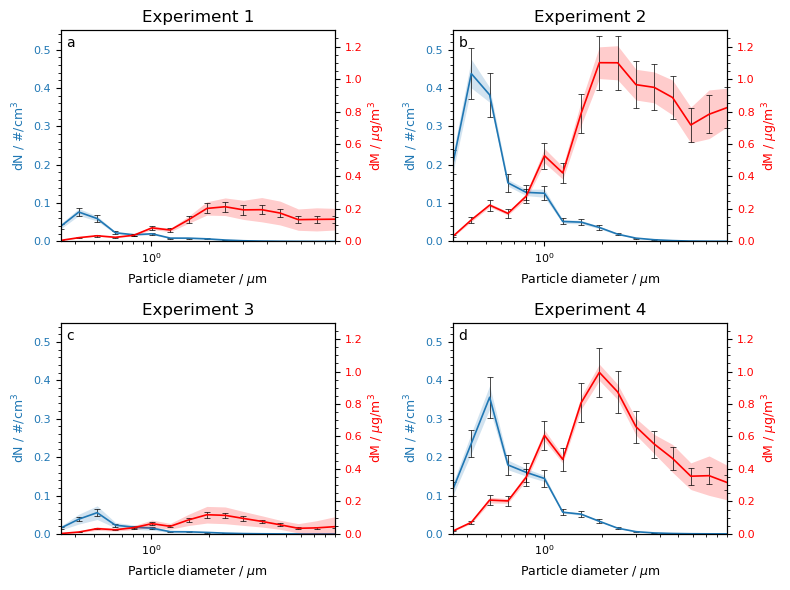

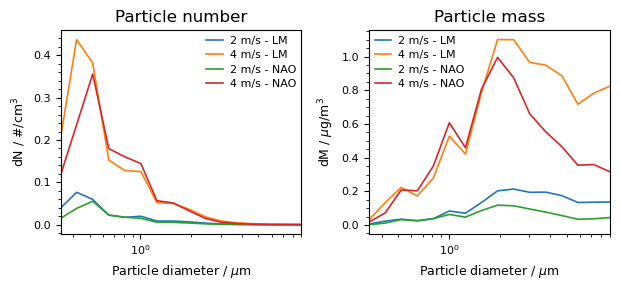

In [5]:
OPS_dict_keys = ['Exp1', 'Exp2', 'Exp3', 'Exp4']
OPS_mid_point = [0.337, 0.419, 0.522, 0.650, 0.809, 1.007, 1.254, 1.562, 1.944, 2.421, 3.014, 3.752, 4.672, 5.816, 7.241, 9.015]
OPS_cut_point = [0.300, 0.374, 0.465, 0.579, 0.721, 0.897, 1.117, 1.391, 1.732, 2.156, 2.685, 3.343, 4.162, 5.182, 6.451, 8.031, 10.000]
OPS_bins = OPS_APS['Exp1'].keys()[1:17].to_list()

OPS_mass_conc = {}
for key in OPS_dict_keys:
    mass_conc = calc_mass_conc(OPS_APS[key], OPS_bins, OPS_mid_point, 7.86)
    OPS_mass_conc[key] = mass_conc

OPS_mean_conc, OPS_axes, OPS_figs = plot_mean_all(timestamps_exp, OPS_APS, OPS_mass_conc, OPS_dict_keys, OPS_bins, OPS_mid_point, 0.15, [0.55, 1.3])

OPS_figs[0].savefig('Mean_concentrations/OPS_mean.png', dpi = 600)
OPS_figs[1].savefig('Mean_concentrations/OPS_mean_all.png', dpi = 600)

In [6]:

# Gaussian function definition
def single_gaussian(x, sigma, mu, A):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2) / (np.sqrt(2 * np.pi) * sigma)

# Multi-Gaussian model for combined fitting
def multi_gaussian(x, *params):
    gaussians = [
        single_gaussian(x, params[i], params[i + 1], params[i + 2])
        for i in range(0, len(params), 3)
    ]
    return np.sum(gaussians, axis=0)

# Detect shoulders
def detect_shoulders(x, y, threshold=0.1):
    dy = np.diff(y)
    d2y = np.diff(dy)
    shoulders = []
    for i in range(2, len(d2y) - 2):
        if d2y[i - 1] > 0 and d2y[i + 1] < 0 and abs(dy[i]) < threshold:
            shoulders.append((x[i - 1], x[i + 1]))
    return shoulders

# Fit function for a single Gaussian
def fit_single_peak(x, y, sy, initial_guess):
    def chi2_single(sigma, mu, A):
        y_fit = single_gaussian(x, sigma, mu, A)
        chi2 = np.sum(((y - y_fit) / sy) ** 2)
        return chi2

    minuit = Minuit(chi2_single, *initial_guess)
    minuit.limits = [(1e-3, None), (None, None), (0, np.max(y))]
    minuit.migrad()
    return minuit.values, minuit.errors

# Main function for fitting
def find_gauss_peaks(x, y, sy, threshold=0.1):
    x, y, sy = np.array(x), np.array(y), np.array(sy)
    df = pd.DataFrame({'x fit': np.linspace(min(x), max(x), 1000)})

    # Step 1: Detect peaks
    peaks, _ = find_peaks(y)
    mu_guess_peaks = x[peaks]
    A_guess_peaks = y[peaks]
    sigma_guess_peaks = [np.ptp(x) / (2 * len(peaks))] * len(peaks)

    # Step 2: Detect shoulders
    shoulders = detect_shoulders(x, y, threshold)

    # Step 3: Fit peaks
    peak_results = []
    for i, peak_idx in enumerate(peaks):
        peak_initial_guess = [sigma_guess_peaks[i], mu_guess_peaks[i], A_guess_peaks[i]]
        fit_x = x[max(peak_idx - 10, 0): min(peak_idx + 10, len(x))]
        fit_y = y[max(peak_idx - 10, 0): min(peak_idx + 10, len(x))]
        fit_sy = sy[max(peak_idx - 10, 0): min(peak_idx + 10, len(x))]
        peak_params, peak_errors = fit_single_peak(fit_x, fit_y, fit_sy, peak_initial_guess)
        df[f'Peak {i + 1}'] = single_gaussian(df['x fit'], *peak_params)
        peak_results.append(peak_params)

    # Step 4: Fit shoulders
    shoulder_results = []
    for i, shoulder in enumerate(shoulders):
        shoulder_mu = np.mean(shoulder)
        shoulder_sigma = (shoulder[1] - shoulder[0]) / 3
        shoulder_center_idx = np.argmin(np.abs(x - shoulder_mu))
        shoulder_A = y[shoulder_center_idx]
        start_idx = max(0, np.searchsorted(x, shoulder[0]))
        end_idx = min(len(x) - 1, np.searchsorted(x, shoulder[1]))
        fit_x = x[start_idx:end_idx]
        fit_y = y[start_idx:end_idx]
        fit_sy = sy[start_idx:end_idx]
        shoulder_initial_guess = [shoulder_sigma, shoulder_mu, shoulder_A]
        shoulder_params, shoulder_errors = fit_single_peak(fit_x, fit_y, fit_sy, shoulder_initial_guess)
        df[f'Shoulder {i + 1}'] = single_gaussian(df['x fit'], *shoulder_params)
        shoulder_results.append(shoulder_params)

    return df

def plot_gauss_fit(ax, x, y, sy, datatype):

    df = find_gauss_peaks(x, y, sy)
    
    n_lines = len(df.keys()) - 1
    cmap = mpl.colormaps['winter']
    colors = cmap(np.linspace(0, 1, n_lines))

    # Plot data and fit
    # ax.plot(x, y, label="Data")
    ax.errorbar(x, y, sy, ecolor='k', elinewidth=0.5, capsize=2, capthick=0.5, label = 'Data', color = 'k')
    
    for key, clr in zip(df.keys()[1:], colors):
        ax.plot(df['x fit'],  df[key], label=key + " fit", linestyle="--", color = clr, zorder = 5)
    ax.legend(fontsize = 8)
    ax.set(xscale='log', xlabel='Particle diameter / $\mu$m')
    if datatype == 'number':
        ax.set_ylabel('dN / #/cm$^{3}$')
    if datatype == 'mass':
        ax.set_ylabel('dM / $\mu$/m$^{3}$')

    return ax, df

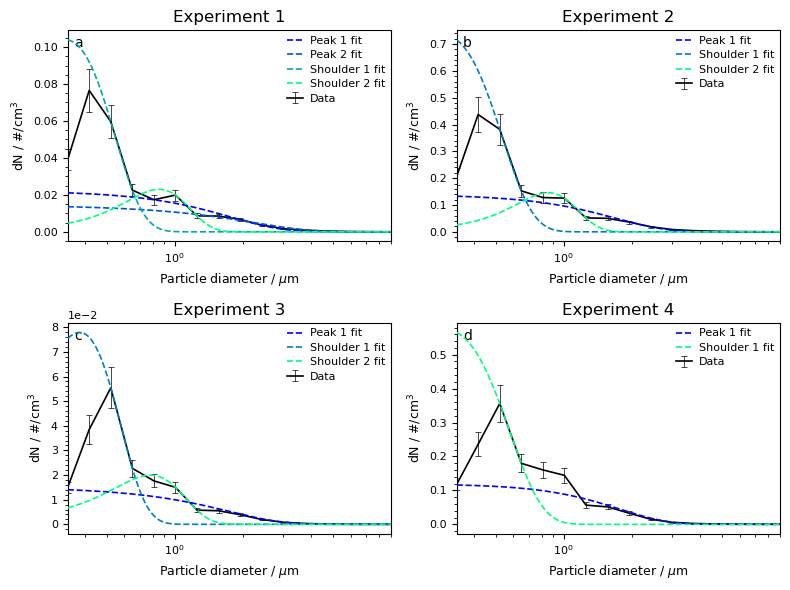

In [7]:
fig, axes = plt.subplots(2, 2, figsize = (8, 6))

for i, key in enumerate(OPS_dict_keys):
    if i == 0:
        ax = axes[0][0]
    if i == 1:
        ax = axes[0][1]
    if i == 2:
        ax = axes[1][0]
    if i == 3:
        ax = axes[1][1]
    
    df = OPS_mean_conc[key]
    ax, y_fit = plot_gauss_fit(ax, df['Diameter'], df['number'], df['error number'], 'number')

    title = 'Experiment ' + str(i + 1)
    ax.set_title(title)

sublabels = ['a', 'b', 'c', 'd']
for ax, l in zip(axes.flatten(), sublabels):
    ax.text(0.02, 0.92, l, transform = ax.transAxes, fontsize = 10)

fig.tight_layout()
fig.savefig('Gaussian_fits/OPS_fitted_number.png', dpi = 600)

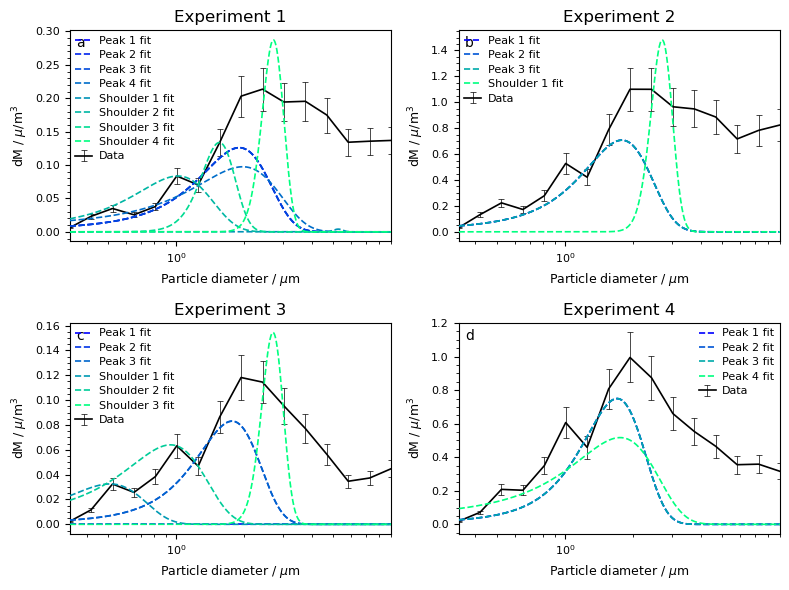

In [8]:
fig, axes = plt.subplots(2, 2, figsize = (8, 6))

for i, key in enumerate(OPS_dict_keys):
    if i == 0:
        ax = axes[0][0]
    if i == 1:
        ax = axes[0][1]
    if i == 2:
        ax = axes[1][0]
    if i == 3:
        ax = axes[1][1]
    
    df = OPS_mean_conc[key]
    ax, y_fit = plot_gauss_fit(ax, df['Diameter'], df['mass'], df['error mass'], 'mass')

    title = 'Experiment ' + str(i + 1)
    ax.set_title(title)

sublabels = ['a', 'b', 'c', 'd']
for ax, l in zip(axes.flatten(), sublabels):
    ax.text(0.02, 0.92, l, transform = ax.transAxes, fontsize = 10)

fig.tight_layout()
fig.savefig('Gaussian_fits/OPS_fitted_mass.png', dpi = 600)

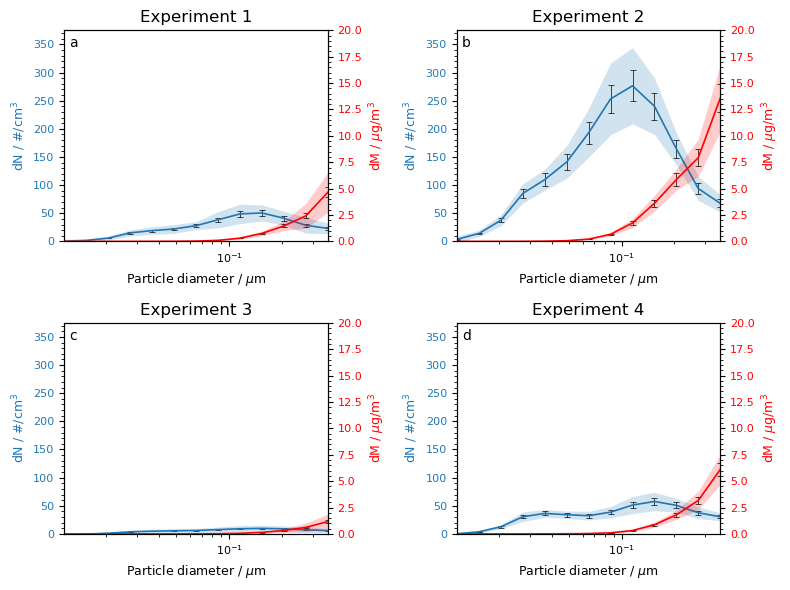

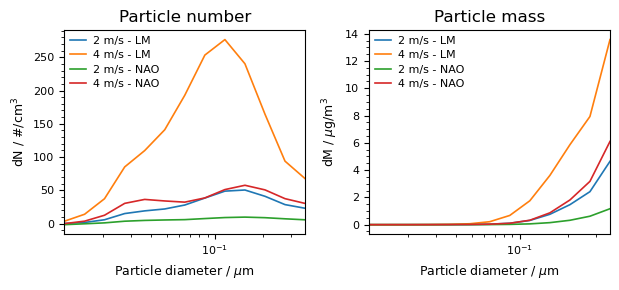

In [9]:
NanoScan_dict_keys = ['2024-10-16_NanoScan', '2024-10-16_NanoScan', '2024-10-17_NanoScan', '2024-10-17_NanoScan']
NanoScan_bin_mean = []
for key in SMPS['2024-10-16_NanoScan'].keys()[3:16]:
    NanoScan_bin_mean.append(float(key) / 1000)
NanoScan_Bins = SMPS['2024-10-16_NanoScan'].keys()[3:16].to_list()

NS_mass_conc = {}
for key in NanoScan_dict_keys:
    mass_conc = calc_mass_conc(SMPS[key], NanoScan_Bins, NanoScan_bin_mean, 7.86)
    NS_mass_conc[key] = mass_conc

NS_mean_conc, NS_axes, NS_figs = plot_mean_all(timestamps_exp, SMPS, NS_mass_conc, NanoScan_dict_keys, NanoScan_Bins, NanoScan_bin_mean, 0.10, [375, 20])

NS_figs[0].savefig('Mean_concentrations/NS_mean.png', dpi = 600)
NS_figs[1].savefig('Mean_concentrations/NS_mean_all.png', dpi = 600)

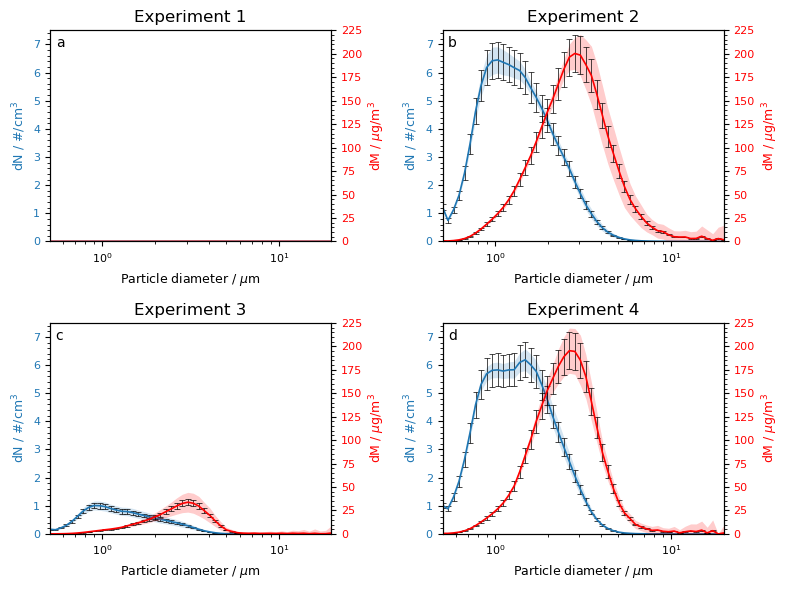

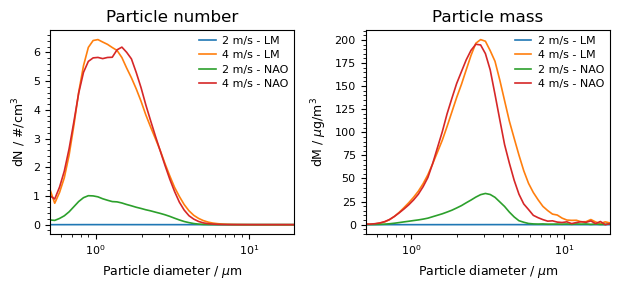

In [ ]:
APS_mean_conc, APS_axes, APS_figs = plot_mean_all(timestamps_exp, OPS_APS, APS_mass_conc, APS_dict_keys, APS_bins, APS_bin_mean, 0.10, [7.5, 225])

APS_figs[0].savefig('Mean_concentrations/APS_mean.png', dpi = 600)
APS_figs[1].savefig('Mean_concentrations/APS_mean_all.png', dpi = 600)

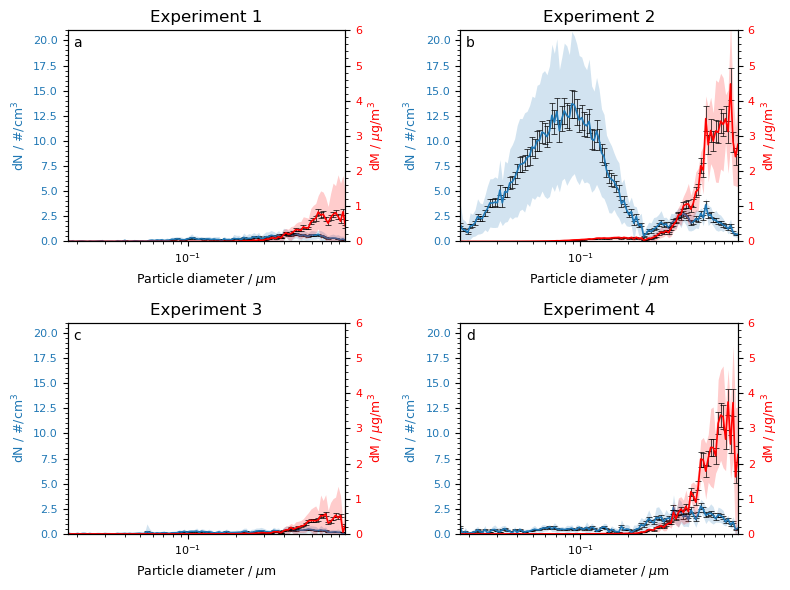

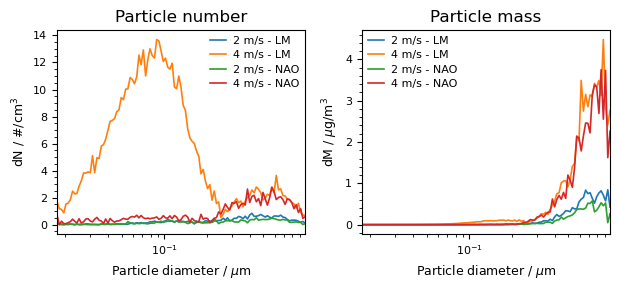

In [11]:
SMPS_mass_conc = {}
for key in SMPS_dict_keys:
    mass_conc = calc_mass_conc(SMPS[key], SMPS_bins, SMPS_bin_mean, 7.86)
    SMPS_mass_conc[key] = mass_conc

SMPS_mean_conc, SMPS_axes, SMPS_figs = plot_mean_all(timestamps_exp, SMPS, SMPS_mass_conc, SMPS_dict_keys, SMPS_bins, SMPS_bin_mean, 0.10, [21, 6])

SMPS_figs[0].savefig('Mean_concentrations/SMPS_mean.png', dpi = 600)
SMPS_figs[1].savefig('Mean_concentrations/SMPS_mean_all.png', dpi = 600)